In [9]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import scipy.io 
import sys
import astropy.constants as const
sys.path.append('/Users/yjzhu/Desktop/Solar/MyPy')
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian, num_to_roman
import cmcrameri.cm as cmcm
from eistrick import eis_slit_width_offset

In [2]:
eis_data_set = scipy.io.readsav("../../save/new_lvl1_offset_limb_1116_northpole_tilt_cor_l1_20071116_07262.sav",verbose=False)
eis_wvl =  np.copy(eis_data_set["wvl"])
eis_wvl[:2048] = eis_wvl[:2048] + 0.10469
eis_wvl[2048:] = eis_wvl[2048:] + 0.11010
eis_img = eis_data_set["new_data_offset"]
eis_err = eis_data_set["new_err_offset"]
eis_img_aver = np.average(eis_img,axis=0)
eis_err_aver = np.sqrt(np.sum(np.square(eis_err),axis=0))/7
eis_range = (372,402)

In [57]:
class SpectrumFitCustomPlot(SpectrumFitSingle):
    def plot_custom(self, plot_fit=True,plot_params=True, plot_mcmc=False,plot_hmc=False,
                color_style="Red",plot_title=None,xlabel=None,ylabel=None,xlim=None,
                line_caption=None,save_fig=False,
                params_prec = {"int":2,"wvl":1,"fwhm":2,"cont":1},
                save_fname="./fit_result.pdf",save_fmt="pdf",save_dpi=300):
        '''
            Plot the input spectra and fitting results. 

            Parameters
            ----------
            plot_fit : bool, optional
            If True, plots the fitting results as well. Default is True.
            plot_params : bool, optional 
            If True, plot the fitted parameters by the figure. Default is True. 
            plot_mcmc : bool, optional 
            If True, plots the MCMC results. Default is False.
            plot_hmc: bool, optional 
            If True, plots the Monte Carlo fitting results using the method described in 
            Hahn et al. 2012, ApJ, 753, 36. Default is False. 
            xlim : [left limit, right_lim], optional 
            If provided, set the left and right limit of the x-axis. Default is None. 
            color_style : {"Red","Yellow","Green","Blue","Purple"}, optional
            Color style of the plot. Default is "Red".
            plot_title : string, optional 
            Set to be the title of the plot. Default is None.
            xlabel: string, optional 
            Set to be the label of the x-axis. Default is None.
            ylabel: string, optional 
            Set to be the label of the y-axis. Default is None. 
            save_fig: bool, optional 
            If True, save the plot to local directory. Default is False.
            save_fname: string, optional 
            The filename of the saved plot. Default is "./fit_result.pdf"
            save_fmt: string, optional 
            Format of the saved file, e.g., "pdf", "png", "svg"... Default is "pdf".
            save_dpi: int, optional
            Dots per inch (DPI) of the saved plot. Default is 300. 

        '''
        if (self.custom_func is not None) and (plot_params is True):
            warn("Use custom function in the fitting. Will not plot fitted parameters.")
            plot_params = False

        self.wvl_plot = np.linspace(self.wvl[0],self.wvl[-1],5*len(self.wvl))
        if (plot_fit is True) and (plot_params is True):
            fig = plt.figure(figsize=(8+3*np.ceil(self.line_number/2),8),constrained_layout=True)
            gs_fig = fig.add_gridspec(1, 2,figure=fig,width_ratios=[8., 3*np.ceil(self.line_number/2)])
            gs_plot = gs_fig[0].subgridspec(2, 1,height_ratios=[5,2])
            ax = fig.add_subplot(gs_plot[0])
            ax_res = fig.add_subplot(gs_plot[1])
        elif (plot_fit is True) and (plot_params is False):
            fig = plt.figure(figsize=(8,9))
            gs_plot = fig.add_gridspec(2, 1,height_ratios=[5,2])
            ax = fig.add_subplot(gs_plot[0])
            ax_res = fig.add_subplot(gs_plot[1])
        else:
            fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
        ax.tick_params(which="both",labelsize=18,right=True,top=True)
        #ax.set_xlabel("Wavelength",fontsize=18)
        if ylabel is None:
            ax.set_ylabel("Intensity",fontsize=18)
        else:
            ax.set_ylabel(ylabel,fontsize=18)
        ax.tick_params(which="major",width=1.2,length=8,direction="in")
        ax.tick_params(which="minor",width=1.2,length=4,direction="in")
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.yaxis.get_offset_text().set_fontsize(18)
        ax.yaxis.get_offset_text().set_y(1.05)
        #print("Wavelength:",self.line_wvl_fit)
        #print("Width:",self.fwhm_fit)
        #print("Width Error:",self.fwhm_err)

        if color_style == "Red":
            colors = ["#E87A90","#FEDFE1","black","#E9002D","#DBD0D0"]
        elif color_style == "Green":
            colors = ["#00896C","#A8D8B9","black","#33A6B8","#DBD0D0"]
        elif color_style == "Yellow":
            colors = ["#FFBA84","#FAD689","black","#FC9F4D","#DBD0D0"]
        elif color_style == "Blue":
            colors = ["#3A8FB7","#A5DEE4","black","#58B2DC","#DBD0D0"]
        elif color_style == "Purple":
            colors = ["#8F77B5","#B28FCE","black","#6A4C9C","#DBD0D0"]


        if self.err is None:
            ln1, = ax.step(self.wvl,self.data,where="mid",color=colors[0],label = r"$I_{\rm obs}$",lw=2,zorder=15)
        else:
            ln1 = ax.errorbar(self.wvl,self.data,yerr = self.err,ds='steps-mid',color=colors[0],capsize=2,
            label = r"$I_{\rm obs}$",lw=2,zorder=15)
        
        ax.fill_between(self.wvl,np.ones_like(self.wvl)*np.min(self.data),self.data,
                        step='mid',color=colors[1],alpha=0.6)

        if self.mask is not None:
            for ii, mask_ in enumerate(self.mask):
                ax.axvspan(mask_[0],mask_[1],color=colors[4],alpha=0.4)


        if plot_fit is True:
            if self.custom_func is not None:
                pass
            elif plot_hmc is True:
                line_wvl_plot = self.line_wvl_fit_hmc
                int_total_plot = self.int_total_fit_hmc
                fwhm_plot = self.fwhm_fit_hmc
                int_cont_plot = self.int_cont_fit_hmc
                line_wvl_err_plot = self.line_wvl_err_hmc
                int_total_err_plot = self.int_total_err_hmc
                fwhm_err_plot = self.fwhm_err_hmc
                int_cont_err_plot = self.int_cont_err_hmc

                int_total_text_fmt = r'$I_0 = {{{:#.{int_data_prec}g}}}' + \
                r'_{{-{:#.{int_err_prec}g}}}^{{+{:#.{int_err_prec}g}}}$'
                line_wvl_text_fmt = r'$\lambda_0 = {{{:#.{wvl_data_prec}g}}}' + \
                r'_{{-{:#.{wvl_err_prec}g}}}^{{+{:#.{wvl_err_prec}g}}}$'
                fwhm_text_fmt = r'$\Delta \lambda = {{{:#.{fwhm_data_prec}g}}}' + \
                r'_{{-{:#.{fwhm_err_prec}g}}}^{{+{:#.{fwhm_err_prec}g}}}$'
                int_cont_text_fmt = r'$I_{{\rm bg}} = {{{:#.{cont_data_prec}g}}}' + \
                r'_{{-{:#.{cont_err_prec}g}}}^{{+{:#.{cont_err_prec}g}}}$'
            else:
                line_wvl_plot = self.line_wvl_fit
                int_total_plot = self.int_total_fit
                fwhm_plot = self.fwhm_fit
                int_cont_plot = self.int_cont_fit
                line_wvl_err_plot = self.line_wvl_err
                int_total_err_plot = self.int_total_err
                fwhm_err_plot = self.fwhm_err
                int_cont_err_plot = self.int_cont_err

                int_total_text_fmt = r'$I_0 = {:#.{int_data_prec}g}\pm{:#.{int_err_prec}g}$'
                line_wvl_text_fmt = r'$\lambda_0 = {:#.{wvl_data_prec}g}\pm{:#.{wvl_err_prec}g}$'
                fwhm_text_fmt = r'$\Delta \lambda = {:#.{fwhm_data_prec}g}\pm{:#.{fwhm_err_prec}g}$'
                int_cont_text_fmt = r'$I_{{\rm bg}} = {:#.{cont_data_prec}g}\pm{:#.{cont_err_prec}g}$'

            if self.custom_func is not None:
                spec_fit = self.custom_func(self.wvl_plot,*self.custom_fit)
                res_fit = self.data_tofit - self.custom_func(self.wvl_tofit,*self.custom_fit)                
            elif self.same_width is True:
                p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                        int_cont_plot),axis=None)
                spec_fit = self.multi_gaussian_same_width(self.wvl_plot,*p_fit)
                res_fit = self.data_tofit - self.multi_gaussian_same_width(self.wvl_tofit,*p_fit) 
            else:
                p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                        int_cont_plot),axis=None)
                spec_fit = self.multi_gaussian_diff_width(self.wvl_plot,*p_fit) 
                res_fit = self.data_tofit - self.multi_gaussian_diff_width(self.wvl_tofit,*p_fit)                           

            ln2, = ax.plot(self.wvl_plot,spec_fit,color=colors[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

            if self.custom_func is None:
                if self.line_number > 1:
                    if self.same_width is True:
                        for jj in range(self.line_number):
                            line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                    int_total_plot[jj], fwhm_plot) \
                                            + int_cont_plot
                            ax.plot(self.wvl_plot,line_profile,color=colors[3],ls="--",lw=2,alpha=0.8)
                    else:
                        for jj in range(self.line_number):
                            line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                    int_total_plot[jj], fwhm_plot[jj]) \
                                            + int_cont_plot
                            ax.plot(self.wvl_plot,line_profile,color=colors[3],ls="--",lw=2,alpha=0.8)   
 

            if self.err is None:
                ax_res.scatter(self.wvl_tofit,res_fit,marker="o",s=15,color=colors[3])
            else:
                ax_res.errorbar(self.wvl_tofit,res_fit,self.err_tofit,ds='steps-mid',color=colors[3],capsize=3,
                                lw=2,ls="none",marker="o",markersize=5)
                chi2_fit = np.sum((res_fit/self.err_tofit)**2)/self.dof
                ax_res.text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(chi2_fit),fontsize=18,
                            ha="right",va="top",transform=ax_res.transAxes)

            ax_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 
            if xlabel is None:
                ax_res.set_xlabel(r"$\textrm{Wavelength}$",fontsize=18)
            else:
                ax_res.set_xlabel(xlabel,fontsize=18)
            ax_res.set_ylabel(r"$r$",fontsize=18)
            ax_res.tick_params(which="both",labelsize=18,top=True,right=True)
            ax_res.tick_params(which="major",width=1.2,length=8,direction="in")
            ax_res.tick_params(which="minor",width=1.2,length=4,direction="in")
            ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

            if xlim is not None:
                ax_res.set_xlim(xlim)
            if self.mask is not None:
                for ii, mask_ in enumerate(self.mask):
                    ax_res.axvspan(mask_[0],mask_[1],color=colors[4],alpha=0.4)


        if xlim is not None:
            ax.set_xlim(xlim)

        if plot_title is not None:
            ax.set_title(plot_title,fontsize=18)

        if (plot_params and plot_fit) is True:
            gs_text = gs_fig[1].subgridspec(2, 1,height_ratios=[5,2])
            text_ncol = np.ceil(self.line_number/2)
            ax_text = fig.add_subplot(gs_text[0])
            ax_text.axis("off")
            if plot_mcmc or plot_hmc:
                for ii in range(self.line_number):
                    int_data_prec = np.ceil(np.log10(np.abs(int_total_plot[ii]))).astype("int") - \
                        np.min(np.ceil(np.log10(int_total_err_plot[:,ii]))).astype("int") + params_prec["int"]
                    

                    ax_text.text(0.05+(ii//2)/text_ncol,0.87-(ii%2)*0.45,int_total_text_fmt.format(num2tex(int_total_plot[ii]),
                    num2tex(int_total_err_plot[0,ii]),num2tex(int_total_err_plot[1,ii]),int_data_prec = int_data_prec,
                    int_err_prec = params_prec["int"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    wvl_data_prec = np.ceil(np.log10(np.abs(line_wvl_plot[ii]))).astype("int") - \
                        np.min(np.ceil(np.log10(line_wvl_err_plot[:,ii])).astype("int")) + params_prec["wvl"]


                    ax_text.text(0.05+(ii//2)/text_ncol,0.78-(ii%2)*0.45,line_wvl_text_fmt.format(num2tex(line_wvl_plot[ii]),
                    num2tex(line_wvl_err_plot[0,ii]),num2tex(line_wvl_err_plot[1,ii]),wvl_data_prec = wvl_data_prec,
                    wvl_err_prec = params_prec["wvl"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    if self.same_width is True:

                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot))).astype("int") - \
                            np.min(np.ceil(np.log10(fwhm_err_plot)).astype("int")) + params_prec["fwhm"]

                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot),
                        num2tex(fwhm_err_plot[0]),num2tex(fwhm_err_plot[1]),fwhm_data_prec = fwhm_data_prec,
                        fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    else:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot[ii]))).astype("int") - \
                            np.min(np.ceil(np.log10(fwhm_err_plot[:,ii]))).astype("int") + params_prec["fwhm"]

                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot[ii]),
                        num2tex(fwhm_err_plot[0,ii]),num2tex(fwhm_err_plot[1,ii]),fwhm_data_prec = fwhm_data_prec,
                        fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    
                    cont_data_prec = np.ceil(np.log10(np.abs(int_cont_plot))).astype("int") - \
                        np.min(np.ceil(np.log10(int_cont_err_plot))).astype("int") + params_prec["cont"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.60-(ii%2)*0.45,int_cont_text_fmt.format(num2tex(int_cont_plot),
                        num2tex(int_cont_err_plot[0]),num2tex(int_cont_err_plot[1]),cont_data_prec = cont_data_prec,
                        cont_err_prec = params_prec["cont"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes) 
            else:
                for ii in range(self.line_number):
                    int_data_prec = np.ceil(np.log10(np.abs(int_total_plot[ii]))).astype("int") - \
                        np.ceil(np.log10(int_total_err_plot[ii])).astype("int") + params_prec["int"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.87-(ii%2)*0.45,int_total_text_fmt.format(num2tex(int_total_plot[ii]),
                    num2tex(int_total_err_plot[ii]),int_data_prec = int_data_prec,int_err_prec = params_prec["int"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    wvl_data_prec = np.ceil(np.log10(np.abs(line_wvl_plot[ii]))).astype("int") - \
                        np.ceil(np.log10(line_wvl_err_plot[ii])).astype("int") + params_prec["wvl"]

                    ax_text.text(0.05+(ii//2)/text_ncol,0.78-(ii%2)*0.45,line_wvl_text_fmt.format(num2tex(line_wvl_plot[ii]),
                    num2tex(line_wvl_err_plot[ii]),wvl_data_prec = wvl_data_prec,wvl_err_prec = params_prec["wvl"]),ha = 'left',va = 'center', 
                    color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)

                    if self.same_width is True:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot))).astype("int") - \
                            np.ceil(np.log10(fwhm_err_plot)).astype("int") + params_prec["fwhm"]
                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot),
                        num2tex(fwhm_err_plot),fwhm_data_prec = fwhm_data_prec,fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    else:
                        fwhm_data_prec = np.ceil(np.log10(np.abs(fwhm_plot[ii]))).astype("int") - \
                            np.ceil(np.log10(fwhm_err_plot[ii])).astype("int") + params_prec["fwhm"]
                        ax_text.text(0.05+(ii//2)/text_ncol,0.69-(ii%2)*0.45,fwhm_text_fmt.format(num2tex(fwhm_plot[ii]),
                        num2tex(fwhm_err_plot[ii]),fwhm_data_prec = fwhm_data_prec,fwhm_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
                    
                    cont_data_prec = np.ceil(np.log10(np.abs(int_cont_plot))).astype("int") - \
                        np.ceil(np.log10(int_cont_err_plot)).astype("int") + params_prec["cont"]
                    ax_text.text(0.05+(ii//2)/text_ncol,0.60-(ii%2)*0.45,int_cont_text_fmt.format(num2tex(int_cont_plot),
                        num2tex(int_cont_err_plot),cont_data_prec = cont_data_prec,cont_err_prec = params_prec["cont"]),ha = 'left',va = 'center', 
                        color = 'black',fontsize = 18,linespacing=1.5,transform=ax_text.transAxes)
            
            if self.line_number > 1:
                if line_caption is None:
                    line_caption = []
                    for ii in range(self.line_number):
                        line_caption.append(r"\textbf{\textsc{"+num_to_roman(ii+1,uppercase=False)+r"}}")
                
                for ii in range(self.line_number):
                    ax_text.text(0.05+(ii//2)/text_ncol,0.95-(ii%2)*0.45,line_caption[ii],
                    ha = 'left',va = 'center',color = 'black',fontsize = 18,linespacing=1.5,
                    transform=ax_text.transAxes)

                    ax_text.axhline(0.915-(ii%2)*0.45,xmin=0.05+(ii//2)/text_ncol,xmax=(ii//2+0.8)/text_ncol,color="#787878",alpha=0.7,lw=4)
            else:
                if line_caption is not None:
                    ax_text.text(0.05+(ii//2)/text_ncol,0.95-(ii%2)*0.45,line_caption,
                    ha = 'left',va = 'center',color = 'black',fontsize = 18,linespacing=1.5,
                    transform=ax_text.transAxes)

        if self.line_number > 1:
            for ii in range(self.line_number):
                if self.same_width is True:
                    ax.text(self.line_wvl_fit[ii],2.355*self.int_total_fit[ii]/self.fwhm_fit/np.sqrt(2*np.pi)+\
                        0.06*np.diff(ax.get_ylim()) + self.int_cont_fit,line_caption[ii],
                    ha = 'center',va = 'bottom',color = colors[3],fontsize = 18,linespacing=1.5,rotation="vertical")

                else:
                    ax.text(self.line_wvl_fit[ii],2.355*self.int_total_fit[ii]/self.fwhm_fit[ii]/np.sqrt(2*np.pi)+\
                        0.06*np.diff(ax.get_ylim()) + self.int_cont_fit,line_caption[ii],
                    ha = 'center',va = 'bottom',color = colors[3],fontsize = 18,linespacing=1.5,rotation="vertical")

                

            ax.set_ylim(top=ax.get_ylim()[1]*1.2)


        if save_fig is True:
            plt.savefig(fname=save_fname,format=save_fmt,dpi=save_dpi)

        return ax, ax_res
        

FWHM after removing instrumental broadening:  [0.03205915 0.02616072 0.04852126 0.0361803  0.0418914 ]


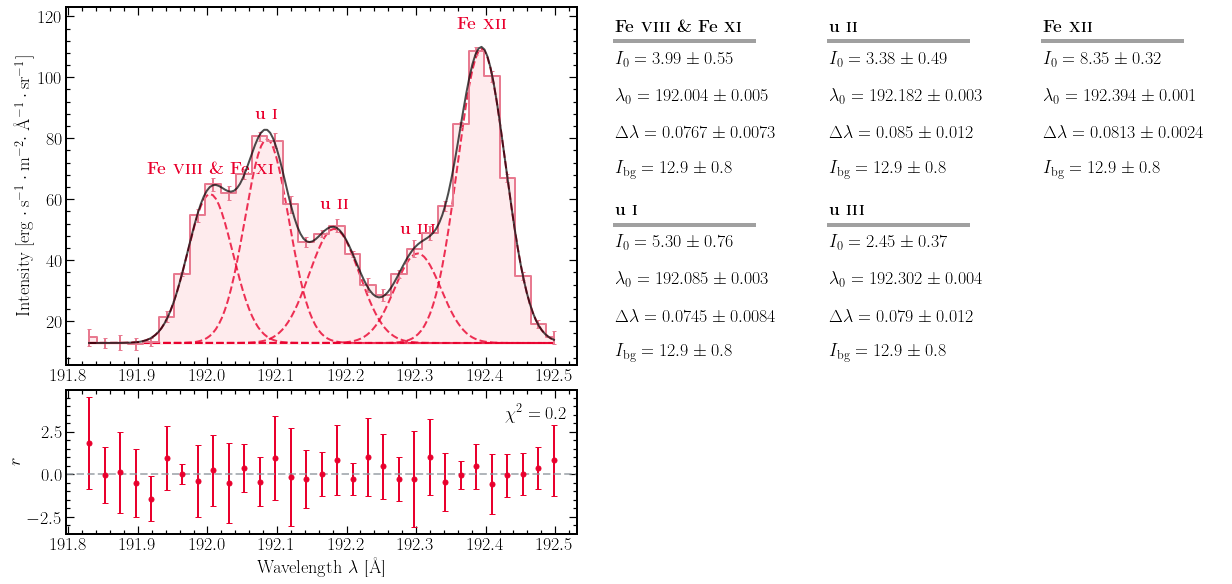

In [58]:
FeVIII_FeXI_192_slice = (1140,1171)
wvl_FeVIII_FeXI_192 = eis_wvl[FeVIII_FeXI_192_slice[0]:FeVIII_FeXI_192_slice[1]]
int_FeVIII_FeXI_192 = np.average(eis_img_aver[eis_range[0]:eis_range[1],
                                    FeVIII_FeXI_192_slice[0]:FeVIII_FeXI_192_slice[1]],axis=0)

err_FeVIII_FeXI_192 = np.sqrt(np.sum(np.square(eis_err_aver[eis_range[0]:eis_range[1],
                        FeVIII_FeXI_192_slice[0]:FeVIII_FeXI_192_slice[1]]),axis=0))/(eis_range[1]-eis_range[0])

FeVIII_FeXI_192_fit_model = SpectrumFitCustomPlot(data=int_FeVIII_FeXI_192,wvl=wvl_FeVIII_FeXI_192,err=err_FeVIII_FeXI_192,
                                      same_width=False,line_number=5,
                                      line_wvl_init=[191.98,192.05,192.18,192.3,192.4],
                                      int_max_init=[50,60,30,30,100],
                                      fwhm_init=[0.08,0.08,0.08,0.08,0.08])
# FeVIII_FeXI_192_fit_model.plot(plot_fit=False,plot_params=False)
# # FeVIII_FeXI_192_fit_model.run_HahnMC(n_chain=10000)
FeVIII_FeXI_192_fit_model.run_lse()
FeVIII_FeXI_192_fit_model.plot(plot_title=None,plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",line_caption=[r"\textbf{Fe \textsc{viii} \& \textbf{Fe \textsc{xi}}}",
                            r"\textbf{u \textsc{i}}",r"\textbf{u \textsc{ii}}",r"\textbf{u \textsc{iii}}",r"\textbf{Fe \textsc{xii}}"],
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
# r"\textbf{Fe \textsc{viii} 192 \mbox{\AA} \& Fe \textsc{xii} 192 \mbox{\AA}"
print("FWHM after removing instrumental broadening: ",np.sqrt(FeVIII_FeXI_192_fit_model.fwhm_fit**2 - \
eis_slit_width_offset(387+256,2,FeVIII_FeXI_192_fit_model.line_wvl_fit,eis_wvl[0])**2))

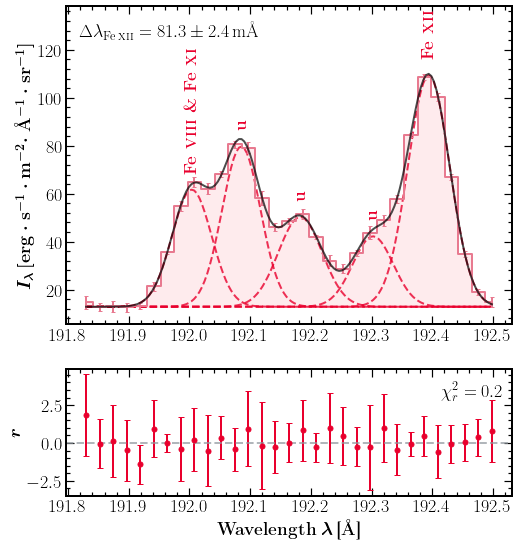

In [63]:
ax, ax_res = FeVIII_FeXI_192_fit_model.plot_custom(plot_title=None,plot_hmc=False,plot_params=False,
    xlabel=r"\textbf{Wavelength} $\boldsymbol{\lambda}$\,\textbf{[\mbox{\AA}]}",line_caption=[r"\textbf{Fe \textsc{viii} \& \textbf{Fe \textsc{xi}}}",
    r"\textbf{u}",r"\textbf{u}",r"\textbf{u}",r"\textbf{Fe \textsc{xii}}"],
    ylabel=r"$\boldsymbol{I_\lambda\, \mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}}$ \textbf{\mbox{\AA}}$\boldsymbol{\mathrm{^{-1}\cdot sr^{-1}]}}$")
ax_res.set_ylabel(r"$\boldsymbol{r}$",fontsize=18)
ax.text(0.03,0.95,r"$\Delta \lambda_{{\mathrm{{Fe}}\,\textsc{{xii}}}} = {:.1f} \pm {:.1f}$\,m\mbox{{\AA}}".format(FeVIII_FeXI_192_fit_model.fwhm_fit[4]*1e3,
FeVIII_FeXI_192_fit_model.fwhm_err[4]*1e3),fontsize=18,ha="left",va="top",transform=ax.transAxes)
plt.savefig(fname="../../figs/ms/multi_gauss_example.pdf",format="pdf",dpi=300)